# Projeto 1 - Ciência dos Dados

Nome: Pedro Herique Britto Aragão Andrade

Nome: Thiago Shiguero Kawahara

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [3]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\thiag\Projeto1-Ciedados


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [4]:
filename = 'Pringles.xlsx'

In [5]:
train = pd.read_excel(filename, sheet_name = 'Treinamento')

train.Classificação = train.Classificação.astype('category')
train.Classificação.cat.categories = (['Irrelevante', 'Relevante'])

train.head(5)

,Treinamento,Classificação
0,eu 🤝 comer pringles com danette\n\n combinaç...,Relevante
1,"@englantinez pipoca, bolinha de amendoim ou ba...",Relevante
2,chorando e comendo pringles,Irrelevante
3,leticia podendo me viciar em tanta coisa me vi...,Relevante
4,vontade de uma pringles ughhhhh,Irrelevante


In [6]:
test = pd.read_excel(filename, sheet_name = 'Teste')

test.Classificação = test.Classificação.astype('category')
test.Classificação.cat.categories = (['Irrelevante', 'Relevante'])

test.head(5)

,Teste,Classificação
0,o cara tem um pote de pringles entre as perna ...,Irrelevante
1,@ellixquintx a pringles de cebola maior que ca...,Irrelevante
2,se eu fosse líder eu n ia falar com a pessoa q...,Relevante
3,vou fazer meu vício favorito dos últimos tempo...,Relevante
4,ai to muito puta namoral ja era a minha coca c...,Relevante


___
## Classificador automático de sentimento


Pringles é um aperitivo estilo batata chips e vendido em um tubo cilíndrico.

Relevante: Avaliações negativas do produto e/ou que tivessem informações interessantes para uma possível parceria ou novas ideias de marketing.

Irrelevante: Todos que não fossem relevantes.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

Utiliza-se o Naive-Bayes para calcular a probabilidade do Tweet ser Relevante e Irrelevante, depois essas probabilidades são comparadas (i) e a partir do resultado é definido se o Tweet é Relevante ou Irrelevante.

i.$\quad  P(R|T) > P(I|T)$ ou $P(R|T) < P(I|T)$ $\quad$ **ETAPA 5**

Para isso, temos que descobrir: 

* $P(R|T)$ 

* $P(I|T)$

As etapas a seguir valem tanto para os **Relevantes** quanto para os **Irrelevantes**.

Sabemos que:

$\quad P(R|T) = \frac{P(T \cap R)}{P(T)}$ $\Rightarrow$ $P(R|T) = \frac{P(T|R) \cdot P(R)}{P(T)}$ $\quad$ **ETAPA 4**

Assim, devemos calcular:

* $P(T|R)$ $\quad$ **ETAPA 3**

$\quad\quad P(T|R) = P(palavra1|R) \cdot P(palavra2|R) \cdot P(palavra3|R) \cdot ... \cdot P(palavraN|R)$

$\quad\quad\quad P(palavra|R) = \frac{x}{y}$

$\quad\quad\quad x=$ total de vezes que a palavra apareceu nos tweets relevantes

$\quad\quad\quad y=$ total de palavras dos tweets relevantes

* $P(R)$ $\quad$ **ETAPA 2** 

$\quad\quad P(R) =$ $\frac{y}{w}$ 

$\quad\quad w=$ total de palavras de todos os tweets 

$\quad$ Para encontrar $y$ e $w$: $\quad$ **ETAPA 1**

$\quad\quad$ - Separar o DataFrame em Relevante e Irrelevante
 
$\quad\quad$ - Contar quantas palavras tem nos tweets Relevantes, Irrelevantes e Total (Relevantes + Irrelevantes)

* Não é preciso calcular $P(T)$, pois esse é cortado na equação de comparação (i).

**LIMPEZA**

Utilizamos duas funções de limpeza (limpandinho() e emoji()) para aumentar a precisão do classificador.

In [7]:
# funcao de limpeza 

def limpandinho(text):
    
    # palavras com suas versoes + acentucao de letras
    dicio = {"sim": ["ss","s","sss","siim"], 
             "porque": ["pq","motivo"],
             "muito": ["mt"],
             "tudo": ["td","todo"],
             "nao": ["ñ", "n", "nn", "nnn"]
            }
    dicio2 = {"a": ["ã","á","à","â", "ä"],
             "e": ["è","é","ê", "ë"],
             "i": ["ì","í","î", "ï"],
             "o": ["õ","ò","ó","ô", "ö"],
             "u": ["ù","ú","û", "ü"],
             "c": ["ç"]
    }

    valores=[]
    for lista in dicio.values():
        for elemento in lista:
            valores.append(elemento)
    valores2=[]
    for lista in dicio2.values():
        for elemento in lista:
            valores2.append(elemento)

    # pega cada LETRA da frase e tira acentuacao (i) + pontuacao(ii)
    l=[]
    l2= []
    for letra in text:
        l.append(letra)
    for letra in l:
        if letra in valores2:
            for l_dicio in dicio2.values():
                # (i)
                if letra in l_dicio:
                    l2.append(list(dicio2.keys())[list(dicio2.values()).index(l_dicio)])
        # (ii)
        elif letra in ["'",'"',"|","!","-",".","/",":","?",";",",",")","(","¿", "_"]:
            pass
                    
        else:
            l2.append(letra)
            
    frase = "".join(l2)
    l_palavras = frase.split()
          
    # pega cada PALAVRA da frase e transforma as palavras abreviadas em seus padroes (iii) + deleta palavras sem valor (iv)
    nova_frase=[]  
    for palavra in l_palavras:
        if palavra in valores:
            for l_dicio in dicio.values():
                # (iii)
                if palavra in l_dicio:
                    nova_frase.append(list(dicio.keys())[list(dicio.values()).index(l_dicio)])     
        elif palavra[:2] == "kk" or palavra=="k":
            palavra = "kkk"
            nova_frase.append(palavra)
            
        # (iv)    
        elif palavra[0] == "@":
            pass
        elif palavra[:4] == "http":
            pass
        elif palavra in ["de","da","do","era","em","que","q","oq"]:
            pass
        else:
            nova_frase.append(palavra)
    
    # retorna a frase ja chamando a funcao emoji()
    return emoji(" ".join(nova_frase))

In [8]:
# funcao de limpeza 

# garante que aja espacamento antes e depois de cada emoji
def emoji(frase):
    l= []
    for palavra in frase:
        for letra in palavra:
            l.append(letra)

    f= ""
    for n in range(len(l)):
        codigo = l[n].encode("utf-8")

        if len(codigo) != len(l[n]):

            if n == len(l)-1:
                if l[n-1] != " ":  f+= " " + l[n]
                else: f+= l[n]
            elif n == 0:
                if l[n+1] != " ":  f+= l[n] + " "
                else: f+= l[n]

            elif l[n-1] == " " and l[n+1] == " ":  f+= l[n]

            elif l[n-1] != " " and l[n+1] == " ": f+= " " + l[n]

            elif l[n-1] == " " and l[n+1] != " ": f+= l[n] + " "

            elif l[n-1] != " " and l[n+1] != " ": f+= " " + l[n] + " "

        else: f+= l[n]
            
    return f

**ETAPA 1**

Calcular o total de palavras dos tweets relevantes e irrelevantes

Calcular o total de palavras de todos os tweets 

In [9]:
# separando a tabela de treinamento em relevante e irrelevante 

train_i = train.loc[train.Classificação=="Irrelevante",:]

train_r = train.loc[train.Classificação=="Relevante",:]

In [10]:
# limpando, juntando todas as frases da tabela treinamento e individualizando cada palavra

# para tabela total
l_t=[]
for i in train.Treinamento:
    l_t.append(limpandinho(i))
l_t = " ".join(l_t).split()


# para tabela somente relevante
l_r=[]
for i in train_r.Treinamento:
    l_r.append(limpandinho(i))   
l_r = " ".join(l_r).split()


# para tabela somente irrelevante 
l_i=[]
for i in train_i.Treinamento:
    l_i.append(limpandinho(i))    
l_i = " ".join(l_i).split()

In [11]:
# contagem das palavras

# para tabela total
tab_total = pd.Series(l_t)
tab_total_a = tab_total.value_counts()
tab_total_r = tab_total.value_counts(True)

# para tabela somente relevante
tab_rel = pd.Series(l_r)
tab_rel_a = tab_rel.value_counts()
tab_rel_r = tab_rel.value_counts(True)

# para tabela somente irrelevante 
tab_irr = pd.Series(l_i)
tab_irr_a = tab_irr.value_counts()
tab_irr_r = tab_irr.value_counts(True)

**ETAPA 2** 

Calcular $P(R)$ e $P(I)$

In [12]:
# probabilidade de ser relevante
probR = sum(tab_rel_a)/sum(tab_total_a)

# probabilidade de ser irrelevante
probI = sum(tab_irr_a)/sum(tab_total_a)

**ETAPA 3**

Calcular $P(T|R)$ e $P(T|I)$

In [13]:
# todos as palavras unicas que aparecem na tabela treinamento (para Laplace smoothing)

palavras_unicas_total=[]
for i in l_t:
    if i not in palavras_unicas_total:
        palavras_unicas_total.append(i)

In [14]:
# limpando e separando cada frase da tabela teste

l_teste=[]
for i in test.Teste:
    c = limpandinho(i)
    l_teste.append(c.split())

**ETAPA 3, 4 e 5**

In [15]:
# criando um DataFrame para o computador preencher

data = {'Tweet':  [],
        'Classificação': [],
        }

novo = pd.DataFrame(data, columns = ['Tweet','Classificação'])

In [16]:
# Legenda: T == Tweet (ex: probTDadoR == prob Tweet dado Relevante)

# contador para acessar a linha desejada da tabela
contador = 0
for frase in l_teste:
    
    # ETAPA 3  Calcular P(T|R) e P(T|I)
    probTDadoR = 1
    for palavra in frase:
        # Laplace smoothing
        if palavra in tab_rel_a:
            probTDadoR*=(tab_rel_a[palavra] + 1) / (len(tab_rel) + len(palavras_unicas_total))
        else:
            probTDadoR*=(0 + 1) / (len(tab_rel) + len(palavras_unicas_total))
                    
    probTDadoI = 1
    for palavra in frase:
        # Laplace smoothing
        if palavra in tab_irr_a:
            probTDadoI*=(tab_irr_a[palavra] + 1) / (len(tab_irr) + len(palavras_unicas_total))
        else:
            probTDadoI*=(0 + 1) / (len(tab_irr) + len(palavras_unicas_total))
      
    # ETAPA 4  Calcular (R|T) e P(I|T)
    probRdadoT = probTDadoR*probR
    
    probIdadoT = probTDadoI*probI
 
    # ETAPA 5
    # comparacao das probabilidades + montando a tabela
    if probRdadoT>probIdadoT:
        
        novo.loc[contador,"Tweet"]= " ".join(frase)
        novo.loc[novo.Tweet==" ".join(frase),"Classificação"] = "Relevante"
    
    elif probRdadoT<probIdadoT:
        
        novo.loc[contador,"Tweet"]=" ".join(frase)
        novo.loc[novo.Tweet==" ".join(frase),"Classificação"] = "Irrelevante"
    
    contador+=1

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [17]:
# criando nova coluna 
novo["Performance"] = "nada"

# verificando e preenchendo a tabela
for i in range(len(novo)):
    if novo.iloc[i, 1] == test.iloc[i,1]:
        if novo.iloc[i, 1] == "Relevante": novo.iloc[i, 2]="VP"
            
        else: novo.iloc[i, 2]="VN"  
    
    elif novo.iloc[i, 1] != test.iloc[i,1]:       
        if novo.iloc[i, 1] == "Relevante": novo.iloc[i, 2]="FP"
            
        else: novo.iloc[i, 2]="FN"            

In [18]:
# calculo das porcentagens

P = novo.Performance.value_counts(normalize=True).round(4)*100
vp = P["VP"]
fp = P["FP"]
vn = P["VN"]
fn = P["FN"]
print(f"Porcentagem de verdadeiros positivos: {vp:.1f}")
print(f"Porcentagem de falsos positivos: {fp:.1f}")
print(f"Porcentagem de verdadeiros negativos: {vn:.1f}")
print(f"Porcentagem de falsos negativos: {fn:.1f}")

Porcentagem de verdadeiros positivos: 12.5
Porcentagem de falsos positivos: 15.5
Porcentagem de verdadeiros negativos: 55.5
Porcentagem de falsos negativos: 16.5


__________
### Concluindo

In [19]:
# Porcentagem relativa a classificacao individual

pd.crosstab(novo.Performance, novo.Classificação, margins= True, normalize="columns").round(4)*100

Classificação,Irrelevante,Relevante,All
Performance,,,
FN,22.92,0.00,16.5
FP,0.00,55.36,15.5
VN,77.08,0.00,55.5
VP,0.00,44.64,12.5


### Performance do classificador:

$\quad$Obtivemos uma porcentagem de acerto considerável, de 68%.

$\quad$Observa-se uma maior porcentagem dos irrelevantes (72%), que pode ter occorrido devido a nossa base de dados em treinamento ter uma maior porcentagem de tweets irrelevantes. E consequentemente, a frequência dos relevantes é menor (28%) devido a sua menor porcentagem na base de dados em treinamentos.

$\quad$Por conta da menor porcentagem de relevantes na base de dados treinamento, o computador tem uma "ideia" mais vaga sobre o que seria um tweet relevante, dificultando uma classificação eficaz dos tweets e também justificando a discrepância entre falsos positivos e verdadeiros positivos ser pequena. O mesmo vale para explicar a discrepância entre os irrelevantes, em que a base de dados é maior e por isso a classificação consegue ser mais precisa.

### Mensagens com dupla negação e sarcasmo:

$\quad$ As mensagens com dupla negação e sarcasmo são tratadas como indiferentes pelo Classificador, ou seja, o sarcasmo e a dupla negação não são identificados. Isso ocorre pelo Classificador não interpretar o contexto da mensagem ou mesmo o sentido da palavra, apenas considerando a palavra como um elemento independente. A única influência da dupla negação e do sarcasmo foi na classificação prévia do tweet (onde nós mesmos declaramos se o tweet é relevante ou irrelevante), levando em consideração o nosso próprio julgamento.

### Plano de expansão:

Visamos duas possíveis expansões para que a empresa continue nos financiando:

* Para obtermos uma maior acuracidade, aumentaríamos a base de dados em treinamento dos tweets relevantes, igualando a proporção entre os tweets relevantes e irrelevantes, assim o Classificador teria uma maior "noção" do que é um tweet relevante.

* Para melhorar a análise e o aproveitamento dos tweets pela empresa, classificaríamos os tweets relevantes em áreas de interesse, como: "marketing", "parcerias", "feedback", entre outras.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [20]:
# funcao para calcular as porcentagens de acerto

def testandinho():
    
    # distribuicao aleatoria nas bases de dados treinamento e teste
    data = {'Tweet':  [],
        'Classificação': [],
        }

    train22 = pd.DataFrame(data, columns = ['Tweet','Classificação'])
    
    data = {'Tweet':  [],
        'Classificação': [],
        }

    test22 = pd.DataFrame(data, columns = ['Tweet','Classificação'])
    
    data = {'Tweet':  [],
        'Classificação': [],
        }

    novo2 = pd.DataFrame(data, columns = ['Tweet','Classificação'])
    
    test2 = []
    train2 = []
    clas_test= []
    clas_train= []

    numeros = []
    for n in range(500):
        numeros.append(n)

    while True:
        if len(numeros)== 0:
            break
        
        elif len(clas_train)< 300:
            random.shuffle(numeros)
            train2.append(tetra.iloc[numeros[0],0])
            clas_train.append(tetra.iloc[numeros[0],1])
            numeros.remove(numeros[0])
        
        elif len(clas_train)== 300:
            random.shuffle(numeros)
            test2.append(tetra.iloc[numeros[0],0])
            clas_test.append(tetra.iloc[numeros[0],1])
            numeros.remove(numeros[0])
        
    contador = 0
    while True:
        try:
            test22.loc[contador,"Tweet"]= test2[contador]
            test22.loc[contador,"Classificação"]= clas_test[contador]

            train22.loc[contador,"Tweet"]= train2[contador]
            train22.loc[contador,"Classificação"]= clas_train[contador]
        except:
            try:
                train22.loc[contador,"Tweet"]= train2[contador]
                train22.loc[contador,"Classificação"]= clas_train[contador]
            except:
                break
        contador+=1
    
    # copia das celulas anteriores
    train22_r = train22.loc[train22.Classificação=="Relevante",:]
    train22_irr = train22.loc[train22.Classificação=="Irrelevante",:]
    
    l_train22_t=[]
    for i in train22.Tweet:
        l_train22_t.append(limpandinho(i))
    l_train22_t = " ".join(l_train22_t).split()

    l_train22_r=[]
    for i in train22_r.Tweet:
        l_train22_r.append(limpandinho(i))
    l_train22_r = " ".join(l_train22_r).split()

    l_train22_irr=[]
    for i in train22_irr.Tweet:
        l_train22_irr.append(limpandinho(i))
    l_train22_irr = " ".join(l_train22_irr).split()
    
    tab_train22_t = pd.Series(l_train22_t)
    tab_train22_t_a = tab_train22_t.value_counts()
    tab_train22_t_r = tab_train22_t.value_counts(True)

    tab_train22_rel = pd.Series(l_train22_r)
    tab_train22_rel_a = tab_train22_rel.value_counts()
    tab_train22_rel_r = tab_train22_rel.value_counts(True)

    tab_train22_irr = pd.Series(l_train22_irr)
    tab_train22_irr_a = tab_train22_irr.value_counts()
    tab_train22_irr_r = tab_train22_irr.value_counts(True)
    
    probR = sum(tab_train22_rel_a)/sum(tab_train22_t_a)
    probI = sum(tab_train22_irr_a)/sum(tab_train22_t_a)
    
    palavras_unicas_total=[]
    for i in l_train22_t:
        if i not in palavras_unicas_total:
            palavras_unicas_total.append(i)
            
    l_teste2=[]
    for i in test22.Tweet:
        c = limpandinho(i)
        l_teste2.append(c.split())
        
    contador = 0
    for frase in l_teste2:
        probTDadoR = 1
        for palavra in frase:
            # Laplace smoothing
            if palavra in tab_train22_rel_a:
                probTDadoR*=(tab_train22_rel_a[palavra] + 1) / (len(tab_train22_rel) + len(palavras_unicas_total))
            else:
                probTDadoR*=(0 + 1) / (len(tab_train22_rel) + len(palavras_unicas_total))


        probTDadoI = 1
        for palavra in frase:
            # Laplace smoothing
            if palavra in tab_train22_irr_a:
                probTDadoI*=(tab_train22_irr_a[palavra] + 1) / (len(tab_train22_irr) + len(palavras_unicas_total))
            else:
                probTDadoI*=(0 + 1) / (len(tab_train22_irr) + len(palavras_unicas_total))

        probRdadoT = probTDadoR*probR

        probIdadoT = probTDadoI*probI

        if probRdadoT>probIdadoT:

            novo2.loc[contador,"Tweet"]= " ".join(frase)
            novo2.loc[novo2.Tweet==" ".join(frase),"Classificação"] = "Relevante"

        elif probRdadoT<probIdadoT:

            novo2.loc[contador,"Tweet"]=" ".join(frase)
            novo2.loc[novo2.Tweet==" ".join(frase),"Classificação"] = "Irrelevante"

        contador+=1
        
    novo2["Performance"] = "nada"
    for i in range(len(novo2)):
        if novo2.iloc[i, 1] == test22.iloc[i,1]:
            if novo2.iloc[i, 1] == "Relevante": novo2.iloc[i, 2]="VP"

            else: novo2.iloc[i, 2]="VN"  

        elif novo2.iloc[i, 1] != test22.iloc[i,1]:       
            if novo2.iloc[i, 1] == "Relevante": novo2.iloc[i, 2]="FP"

            else: novo2.iloc[i, 2]="FN"
    
    P = novo2.Performance.value_counts(normalize=True).round(4)*100
    vp = P["VP"]
    fp = P["FP"]
    vn = P["VN"]
    fn = P["FN"]
    return (vn + vp)

In [21]:
# criando um DataFrame

data = {'Tweet':  [],
        'Classificação': [],
        }

tetra = pd.DataFrame(data, columns = ['Tweet','Classificação'])

In [22]:
# criando um DataFrame com tweets de test + train

contador= 0
while True:
    try:
        tetra.loc[contador,"Tweet"]= test.loc[contador,"Teste"]
        tetra.loc[contador,["Classificação"]]= test.loc[contador,["Classificação"]]
    except:
        try:
            tetra.loc[contador,"Tweet"]= train.loc[contador-200,"Treinamento"]
            tetra.loc[contador,["Classificação"]]= train.loc[contador-200,["Classificação"]]
        except:
            break
    contador+= 1

In [23]:
# rodando 100 vezes a funcao testandinho()

vezes= 100
lista= []
for i in range(vezes):
    lista.append(testandinho())
    # como o programa demora um pouco para rodar, adicionamos um contador para acompanhar o progresso
    if i%10== 0:
        print("Contagem", i)
    if i== vezes-1:
        print("Contagem", vezes)

Contagem 0
Contagem 10
Contagem 20
Contagem 30
Contagem 40
Contagem 50
Contagem 60
Contagem 70
Contagem 80
Contagem 90
Contagem 100


In [24]:
mini= min(lista)-5
maxi= max(lista)+5

faixa= np.arange(mini, maxi, 1)

In [28]:
# medidas resumo
porcentagens= pd.Series(lista)
porcentagens.describe().round(2)

count    100.00
mean      67.65
std        2.79
min       61.00
25%       66.00
50%       67.50
75%       69.00
max       75.50
dtype: float64

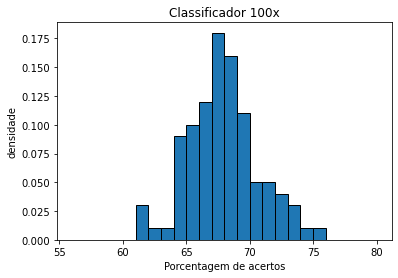

In [29]:
plt.hist(lista, faixa, edgecolor="black", density= True)
plt.title(f"Classificador {vezes}x")
plt.xlabel("Porcentagem de acertos")
plt.ylabel("densidade")

plt.show()

### Discussão sobre o histograma:

$\quad$Dentro das 10.000 Classificações, obtivemos uma média de acerto moderada de aproximadamente 67%.

$\quad$A desvantagem de se construir um Classificador considerando uma única vez a divisão da base de dados em treinamento e teste é a chance de o classificador não estar na sua real eficiência (porcentagem de acerto de 67%), podendo estar muito abaixo ou muito acima, o que pode iludir o analista sobre a eficiência do seu classificador.

$\quad$Ao construir a base de dados em treinamento aleatóriamente, há a chance de se pegar muitos dados relevantes ou muitos dados irrelevantes, não só tendendo o classificador a uma dessas extremidades, como o fazendo perder acurácia pela falta de informações na base de dados. Acreditamos que esse seja o motivo de algumas porcentagens no histograma estarem significamente fora da média.

### Porquê não se pode usar o próprio classificador para gerar mais amostras de treinamento:

$\quad$A partir da base de dados em treinamento, o Classificador define o que considera relevante e o que considera irrelevante. Sabemos que nem sempre a definição do Classificador bate com a definição real e, portanto, sabemos que apresenta certos erros. Ao Classificador alimentar a sua própria base de treinamento, esses erros se tornam "verdades", o que irá diminuir a sua precisão, pois agora o correto para o Classificador não é de fato a verdade dada por nós.

### Diferentes cenários para Naïve Bayes fora do contexto do projeto:

**1. Previsão do tempo:** 

$\quad$Usaríamos o Naive Bayers para identificar um padrão nas condições prévias de determinados climas, e assim, dados certas condições o Classificador poderia declarar qual a previsão do tempo.

$\quad$Exemplo: "Umidade", "Luminosidade", "Temperatura", etc. $\Rightarrow$ "Sol" ou "Chuva" ou "Granizo" ou etc.

**2. Identificação de pessoas de exatas, humanas e biológicas:**

$\quad$A partir do seu perfil escolar, como: notas, atividades extracurrículares, gostos, etc. O Classificador identificaria um padrão e conseguiria determinar qual área o aluno se encaixaria melhor. Essa análise ajudaria em testes vocacionais, onde a pessoa teria um melhor direcionamento baseado em pessoas com o mesmo perfil.

### Melhoria para o Classificador Naive-Bayes:

**TF-IDF**

$\quad$Implementaríamos o medidor TF-IDF para valorizar as palavras que aparecem com maior frequência em somente uma das classificações (Relevante ou Irrelevante) e com menor frequência na outra classificação; e desvalorizar as palavras que aparecem com altas frequências nas duas classificações. Essa melhoria permitiria o classificador identificar palavras-chave nas categorias relevante e irrelevante, o que acarretaria em um julgamento mais iniludível.

**Link para a matéria:**
https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-a-bag-of-words-e-tf-idf-43a128151ce9

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* ~~Limpar: \n, :, ", ', (, ), etc SEM remover emojis~~
* ~~Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis~~
* ~~Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação~~
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* ~~Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento~~
* ~~Propor diferentes cenários para Naïve Bayes fora do contexto do projeto~~
* ~~Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)~~


___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**